## **Deep Recurrent Q-Network (DRQN)**
Pavlos Ntais - 1115202100122

### **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

### **Hyperparameters**

In [4]:
learning_rate           = 1e-3
gamma                   = 0.99
epsilon_start           = 1.0
epsilon_decay           = 0.995
epsilon_end             = 0.05
batch_size              = 128
buffer_size             = 10000
target_update_frequency = 10
hidden_dim              = 128
num_episodes            = 930
seed_n                  = 42

In [5]:
# check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# initialize environment
env        = gym.make('MountainCar-v0')
input_dim  = env.observation_space.shape[0]
output_dim = env.action_space.n

In [7]:
def set_rand_env(env, seed=seed_n):
    env.action_space.seed(seed)
    state, _ = env.reset(seed=seed)

def set_rand(seed=seed_n):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    
set_rand_env(env)
set_rand()

In [8]:
# initialize networks, optimizer and replay buffer
policy_net = DQN(input_dim, output_dim, hidden_dim).to(device)
target_net = DQN(input_dim, output_dim, hidden_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer     = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(buffer_size)

In [9]:
def compute_rolling_average(rewards, window_size=10):
    """
    Computes the rolling average of rewards.

    Args:
        rewards (list): List of rewards per episode.
        window_size (int): Number of episodes to average over.

    Returns:
        list: Rolling average rewards.
    """
    return [
        np.mean(rewards[max(0, i - window_size + 1):i + 1])
        for i in range(len(rewards))
    ]

def plot_rewards(results, param_name, window_size=10):
    """
    Plots the average rewards (rolling average) for each tested value of a hyperparameter.

    Args:
        results (list): List of dictionaries containing 'value' and 'rewards'.
        param_name (str): Name of the hyperparameter being tested.
        window_size (int): Number of episodes for rolling average.
    """
    plt.figure(figsize=(12, 6))

    if (param_name == "gamma"):           param_n = "gamma"
    elif (param_name == "batch_size"):    param_n = "batch size"
    elif (param_name == "learning_rate"): param_n = "learning rate"
    else:                                 param_n = "target update frequency"
     
    for result in results:
        value       = result["value"]
        rewards     = result["rewards"]
        avg_rewards = compute_rolling_average(rewards, window_size=window_size)

        plt.plot(avg_rewards, label=f"{param_n}={value}")

    plt.title(f"Average rewards for values of {param_n}")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

def plot_single_reward(rewards, title, window_size=10):
    """
    Plots the average rewards (rolling average) for a single run.

    Args:
        rewards (list): List of rewards for each episode.
        title (str): Title of the graph.
        window_size (int): Number of episodes for rolling average.
    """
    avg_rewards = compute_rolling_average(rewards, window_size=window_size)
    
    plt.figure(figsize=(12, 6))
    plt.plot(avg_rewards)
    
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

### **Deep Q-Network (DQN)**

In [10]:
def train_dqn(verbose=False):
    epsilon             = epsilon_start
    rewards_per_episode = list()

    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        done           = False
        episode_reward = 0

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = policy_net(state_tensor).argmax().item()

            next_step = env.step(action)
            if isinstance(next_step, tuple) and len(next_step) == 5:  # Gymnasium style
                next_state, reward, terminated, truncated, _ = next_step
                done = terminated or truncated
            else:
                next_state, reward, done, _ = next_step

            episode_reward += reward

            # store transition in replay buffer
            replay_buffer.push((state, action, reward, next_state, done))

            state = next_state

            if len(replay_buffer) >= batch_size:
                # sample a batch of transitions from the replay buffer
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # move data to GPU if available
                states      = states.to(device)
                actions     = actions.to(device)
                rewards     = rewards.to(device)
                next_states = next_states.to(device)
                dones       = dones.to(device)

                # compute Q-values
                q_values        = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values   = target_net(next_states).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

                # Compute loss and update the policy network
                loss = nn.MSELoss()(q_values, target_q_values.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update the target network
            if episode % target_update_frequency == 0:
                target_net.load_state_dict(policy_net.state_dict())

        # decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # record the episode reward
        rewards_per_episode.append(episode_reward)

        # print statistics
        if verbose and episode % 10 == 0 and episode != 0:
            avg_reward = np.mean(rewards_per_episode[-10:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Reward = {episode_reward} , Epsilon: {epsilon:.2f}")

    env.close()
    return rewards_per_episode

/tmp/ipykernel_17/3162173711.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor(states, dtype=torch.float32),


Episode 10, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.95
Episode 20, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.90
Episode 30, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.86
Episode 40, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.81
Episode 50, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.77
Episode 60, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.74
Episode 70, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.70
Episode 80, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.67
Episode 90, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.63
Episode 100, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.60
Episode 110, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.57
Episode 120, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.55
Episode 130, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.52
Episode 140, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.49
Episode 150, Average Reward: 

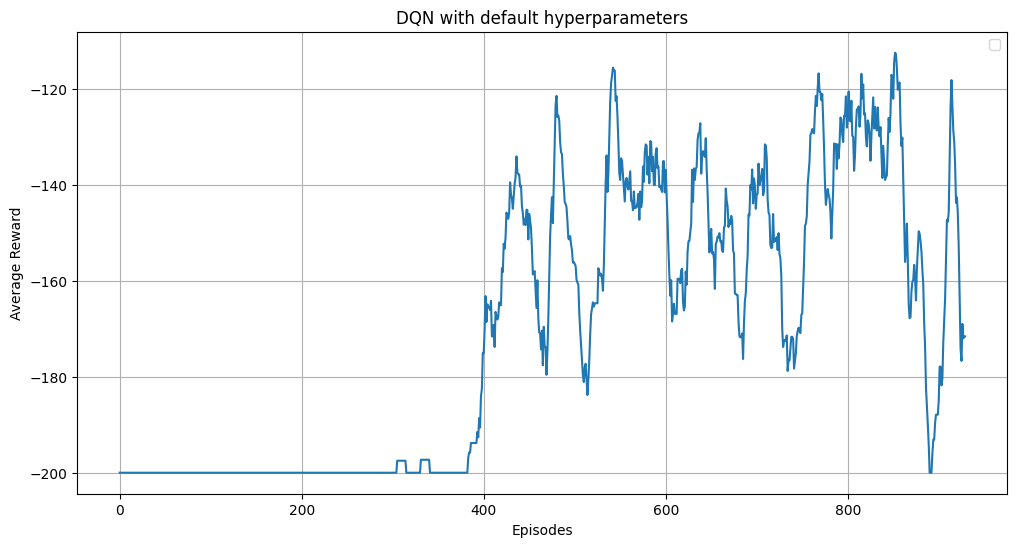

In [11]:
default_rewards = train_dqn(True)
plot_single_reward(default_rewards, title="DQN with default hyperparameters")

### **Sensitivity Study - DQN**

- learning rate (1e-3, 3e-3, 7e-3, 1e-4)
- batch size (32, 64, 128, 256)
- gamma (0.90, 0.95, 0.97, 0.99)
- target network update frequency (10, 20, 35, 50)

In [12]:
# default hyperparameters
default_hyperparameters = {
    "learning_rate": 1e-3,
    "batch_size": 128,
    "gamma": 0.99,
    "target_update_frequency": 10,
}

hyperparameter_values = {
    "learning_rate": [1e-3, 3e-4, 7e-3, 1e-4],
    "batch_size": [32, 64, 128, 256],
    "gamma": [0.90, 0.95, 0.97, 0.99],
    "target_update_frequency": [10, 20, 35, 50],
}

In [13]:
def set_hyperparameters(lr, b_size, gamma_v, tupdate_freq):
    global replay_buffer, optimizer, policy_net, target_net
    global learning_rate, batch_size, gamma, target_update_frequency

    # set hyperparameters
    learning_rate           = lr
    batch_size              = b_size
    gamma                   = gamma_v
    target_update_frequency = tupdate_freq
    
    # reset replay buffer and networks
    replay_buffer = ReplayBuffer(buffer_size)
    policy_net = DQN(input_dim, output_dim, hidden_dim).to(device)
    target_net = DQN(input_dim, output_dim, hidden_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

def run_experiment(env, set_hyper_func, lr, b_size, gamma_v, tupdate_freq):
    set_rand_env(env)
    set_rand()
    set_hyper_func(lr, b_size, gamma_v, tupdate_freq)

    print(f"Set hyperparameters: Learning Rate={learning_rate}, Batch Size={batch_size}, Gamma={gamma}, Target Update Frequency={target_update_frequency}")
    
    return train_dqn()

def hyperparameter_test(set_hyper_func, default_rewards=None):
    for param, values in hyperparameter_values.items():
        print(f"Testing hyperparameter: {param}")
        param_results = list()
        
        b_size  = default_hyperparameters["batch_size"]
        gamma_v = default_hyperparameters["gamma"]
        tuf     = default_hyperparameters["target_update_frequency"]
        lr      = default_hyperparameters["learning_rate"]
    
        for value in values:
            # set hyperparameters
            if param == "learning_rate": lr = value
            elif param == "batch_size":  b_size = value
            elif param == "gamma":       gamma_v = value
            else:                        tuf = value

            if lr == default_hyperparameters["learning_rate"] and b_size == default_hyperparameters["batch_size"] and gamma_v == default_hyperparameters["gamma"] and tuf == default_hyperparameters["target_update_frequency"]:
                param_results.append({
                    "value": value,
                    "rewards": default_rewards
                })
                continue
            
            cumulative_rewards = run_experiment(env, set_hyper_func, lr, b_size, gamma_v, tuf)
            param_results.append({
                "value": value,
                "rewards": cumulative_rewards
            })
        plot_rewards(param_results, param, window_size=10)

Testing hyperparameter: learning_rate
Set hyperparameters: Learning Rate=0.0003, Batch Size=128, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.007, Batch Size=128, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.0001, Batch Size=128, Gamma=0.99, Target Update Frequency=10


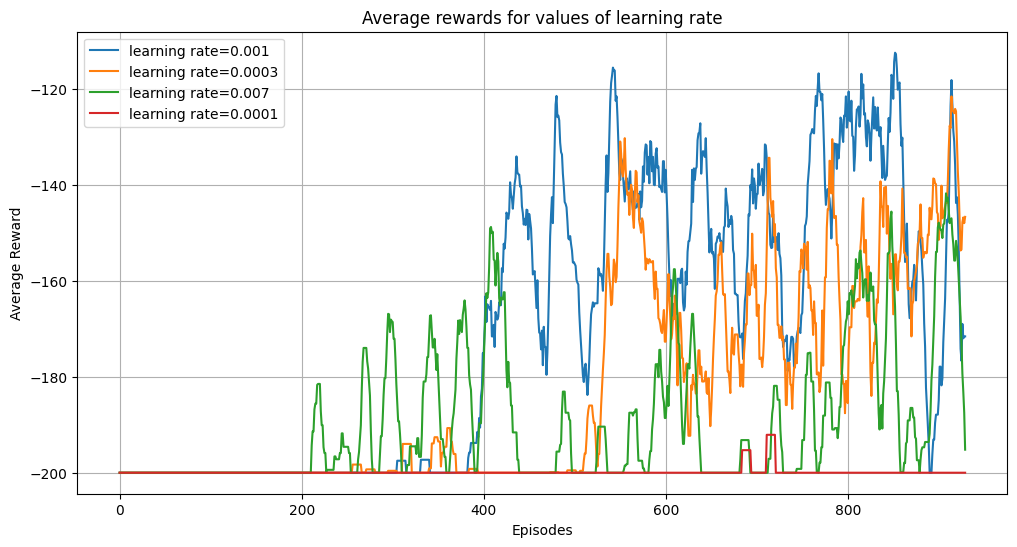

Testing hyperparameter: batch_size
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=64, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=256, Gamma=0.99, Target Update Frequency=10


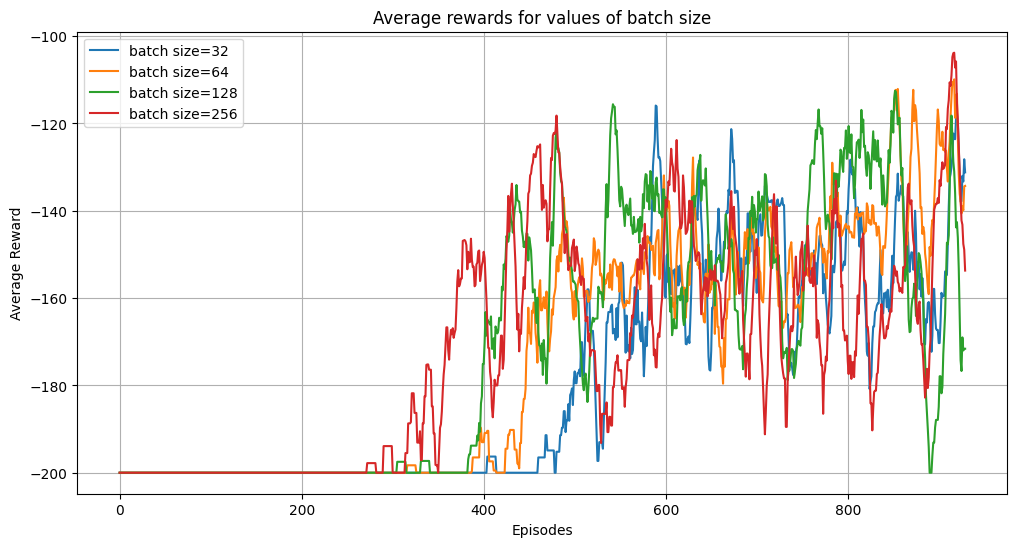

Testing hyperparameter: gamma
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.9, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.95, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.97, Target Update Frequency=10


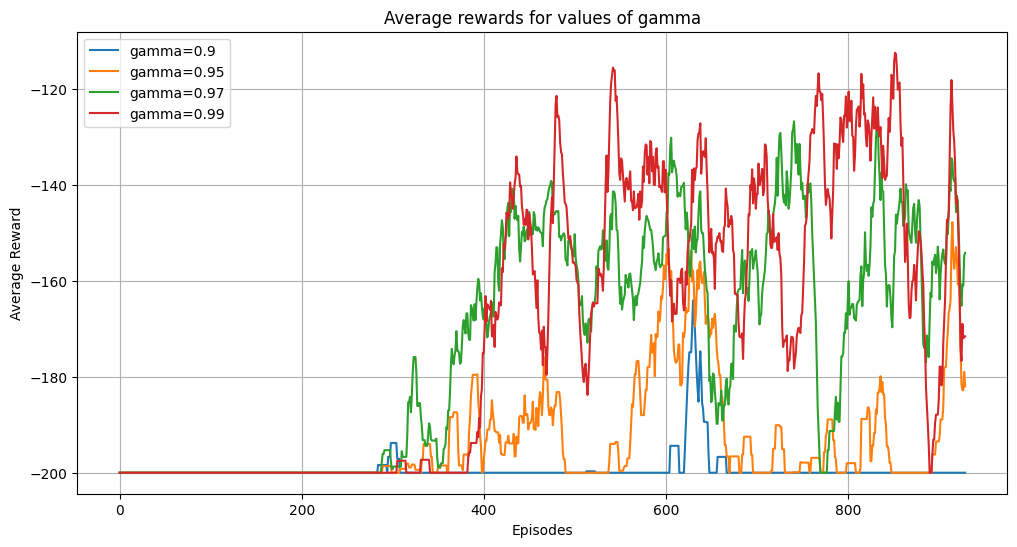

Testing hyperparameter: target_update_frequency
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.99, Target Update Frequency=20
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.99, Target Update Frequency=35
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.99, Target Update Frequency=50


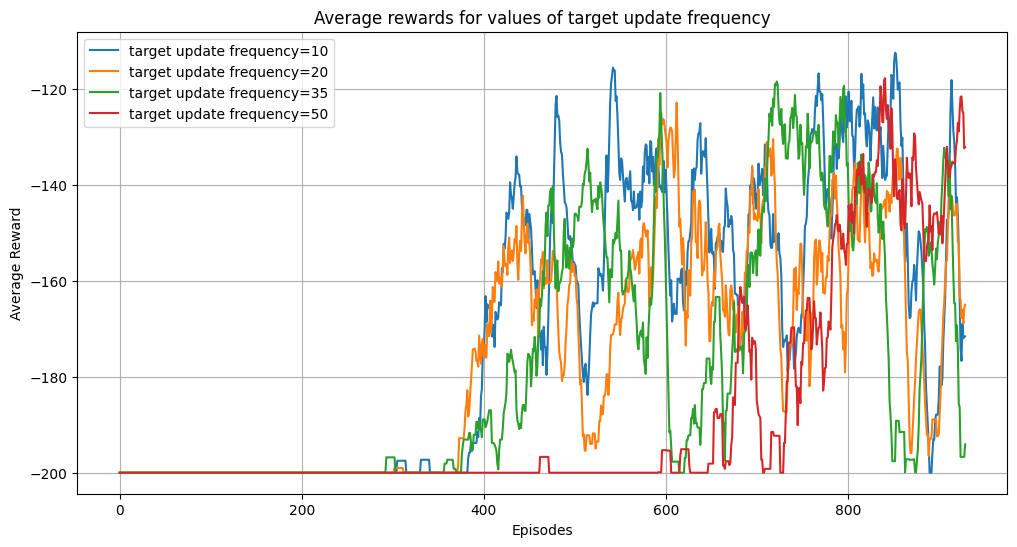

In [14]:
hyperparameter_test(set_hyperparameters, default_rewards)

### **Advanced Algorithms - Noisy Networks**

Implemented [Noisy Networks](https://arxiv.org/abs/1706.10295)

In [15]:
import torch
import torch.nn as nn
import math

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # standard weight and bias
        self.weight_mu    = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu      = nn.Parameter(torch.empty(out_features))
        self.bias_sigma   = nn.Parameter(torch.empty(out_features))

        # noise buffers
        self.register_buffer('weight_epsilon', torch.zeros(out_features, in_features))
        self.register_buffer('bias_epsilon', torch.zeros(out_features))

        # initialize parameters
        self.reset_parameters(sigma_init)

    def reset_parameters(self, sigma_init):
        # Initialize weights and biases
        bound = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(sigma_init)
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(sigma_init)

    def forward(self, x):
        if self.training:
            self.sample_noise()
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu

        return nn.functional.linear(x, weight, bias)

    def sample_noise(self):
        epsilon_in = self._f(torch.randn(self.in_features))
        epsilon_out = self._f(torch.randn(self.out_features))
        self.weight_epsilon.copy_(torch.outer(epsilon_out, epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    @staticmethod
    def _f(x):
        return x.sign() * x.abs().sqrt()

class NoisyDQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(NoisyDQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            NoisyLinear(hidden_dim, hidden_dim),  # Noisy layer
            nn.ReLU(),
            NoisyLinear(hidden_dim, output_dim)   # Noisy layer
        )

    def forward(self, x):
        return self.network(x)

In [16]:
batch_size              = default_hyperparameters["batch_size"]
gamma                   = default_hyperparameters["gamma"]
target_update_frequency = default_hyperparameters["target_update_frequency"]
learning_rate           = default_hyperparameters["learning_rate"]

set_rand_env(env)
set_rand()

policy_net = NoisyDQN(input_dim, output_dim, hidden_dim).to(device)
target_net = NoisyDQN(input_dim, output_dim, hidden_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(buffer_size)

Episode 10, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.95
Episode 20, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.90
Episode 30, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.86
Episode 40, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.81
Episode 50, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.77
Episode 60, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.74
Episode 70, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.70
Episode 80, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.67
Episode 90, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.63
Episode 100, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.60
Episode 110, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.57
Episode 120, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.55
Episode 130, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.52
Episode 140, Average Reward: -200.00, Reward = -200.0 , Epsilon: 0.49
Episode 150, Average Reward: 

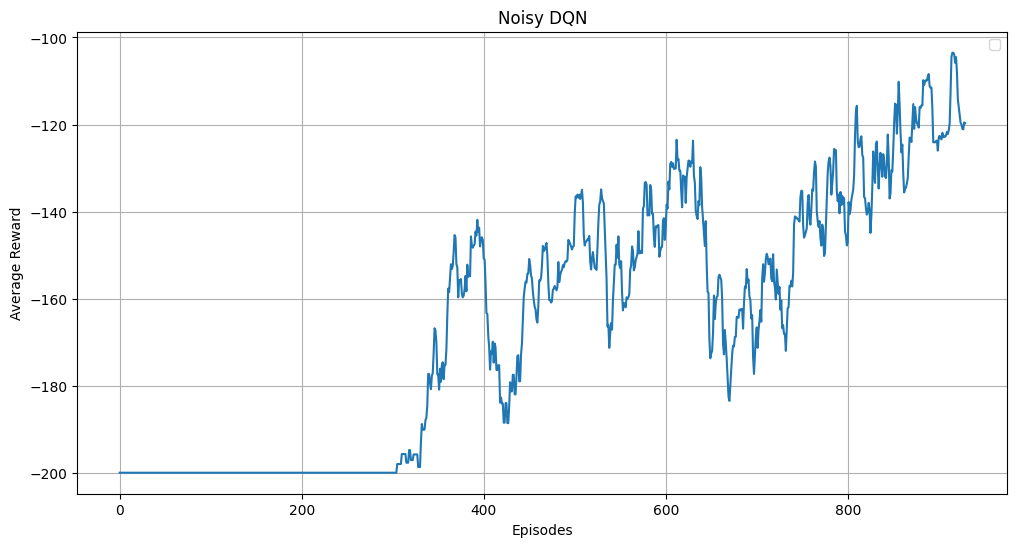

In [17]:
rewards_noisy = train_dqn(True)
plot_single_reward(rewards_noisy, title="Noisy DQN")

### **Sensitivity Study - Noisy DQN**

- learning rate (1e-3, 3e-3, 7e-3, 1e-4)
- batch size (32, 64, 128, 256)
- gamma (0.90, 0.95, 0.97, 0.99)
- target network update frequency (10, 20, 35, 50)

In [18]:
def set_hyperparameters_noisy(lr, b_size, gamma_v, tupdate_freq):
    global replay_buffer, optimizer, policy_net, target_net
    global learning_rate, batch_size, gamma, target_update_frequency

    # set hyperparameters
    learning_rate           = lr
    batch_size              = b_size
    gamma                   = gamma_v
    target_update_frequency = tupdate_freq

    # reset replay buffer and networks
    replay_buffer = ReplayBuffer(buffer_size)
    policy_net = NoisyDQN(input_dim, output_dim, hidden_dim).to(device)
    target_net = NoisyDQN(input_dim, output_dim, hidden_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

Testing hyperparameter: learning_rate
Set hyperparameters: Learning Rate=0.0003, Batch Size=128, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.007, Batch Size=128, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.0001, Batch Size=128, Gamma=0.99, Target Update Frequency=10


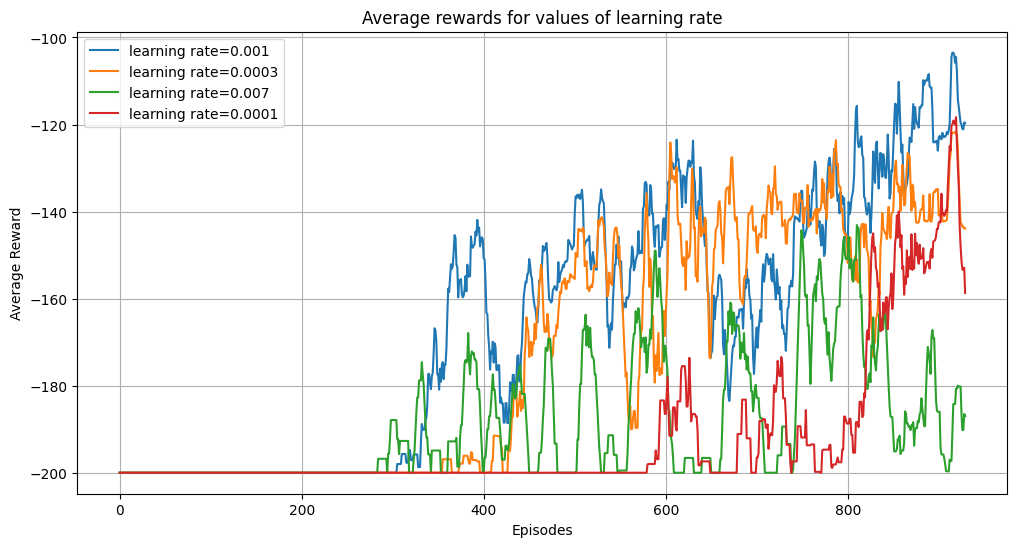

Testing hyperparameter: batch_size
Set hyperparameters: Learning Rate=0.001, Batch Size=32, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=64, Gamma=0.99, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=256, Gamma=0.99, Target Update Frequency=10


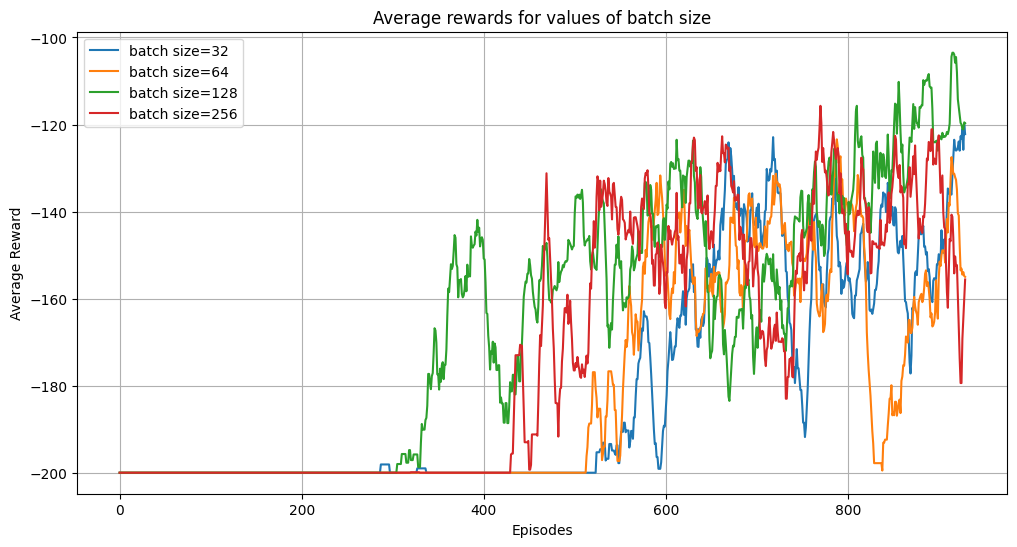

Testing hyperparameter: gamma
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.9, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.95, Target Update Frequency=10
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.97, Target Update Frequency=10


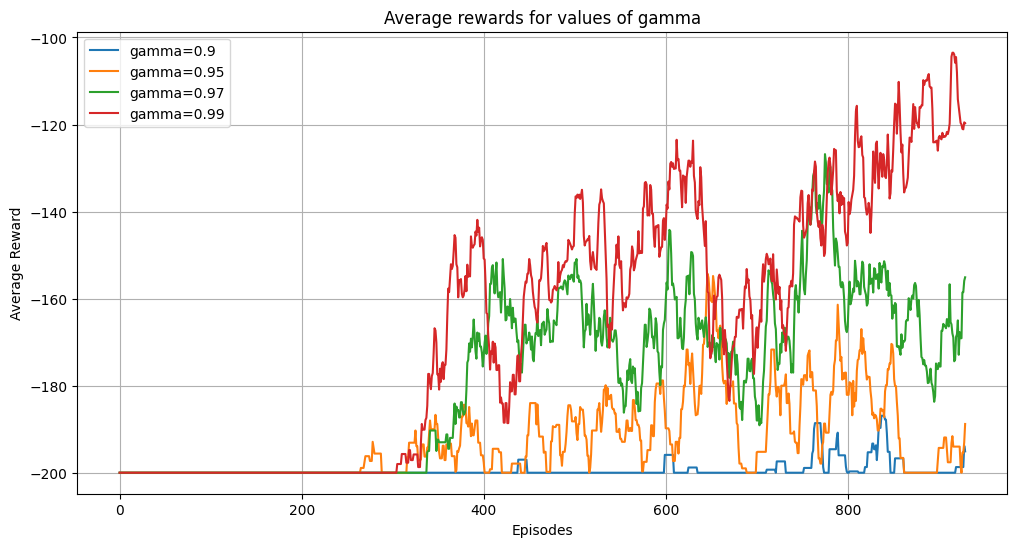

Testing hyperparameter: target_update_frequency
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.99, Target Update Frequency=20
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.99, Target Update Frequency=35
Set hyperparameters: Learning Rate=0.001, Batch Size=128, Gamma=0.99, Target Update Frequency=50


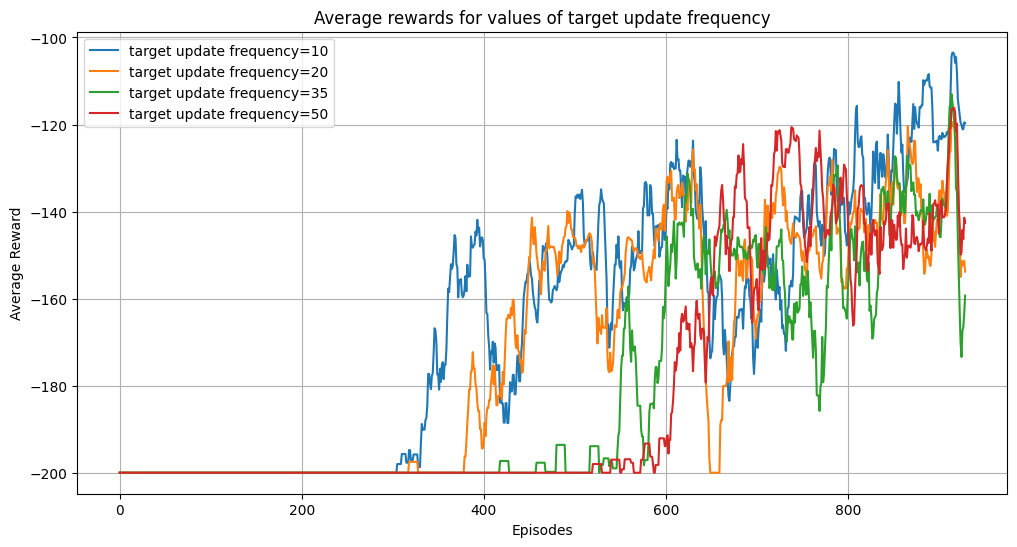

In [19]:
hyperparameter_test(set_hyperparameters_noisy, rewards_noisy)